In [11]:
import pandas as pd
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBClassifier, XGBRegressor

In [12]:
df = pd.read_csv("./outputs/train_processed.csv")
df.sample(20)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,month,day,hour
9538,4,0,1,1,18.04,21.970,47,12.9980,11,10,11,1
983,1,0,1,1,12.30,14.395,33,15.0013,145,3,7,19
3734,3,0,0,1,25.42,28.030,88,0.0000,108,9,11,0
7134,2,0,1,1,28.70,32.575,54,31.0009,643,5,4,17
8164,3,0,1,1,28.70,33.335,74,8.9981,16,7,10,2
9405,4,0,1,1,23.78,27.275,64,0.0000,785,10,5,8
7591,2,0,1,1,23.78,27.275,49,19.9995,86,6,4,23
10255,4,0,1,1,17.22,21.210,77,11.0014,10,12,3,2
4408,4,0,1,1,18.04,21.970,62,8.9981,135,11,1,10
8536,3,0,1,1,31.98,37.120,59,12.9980,640,8,6,19


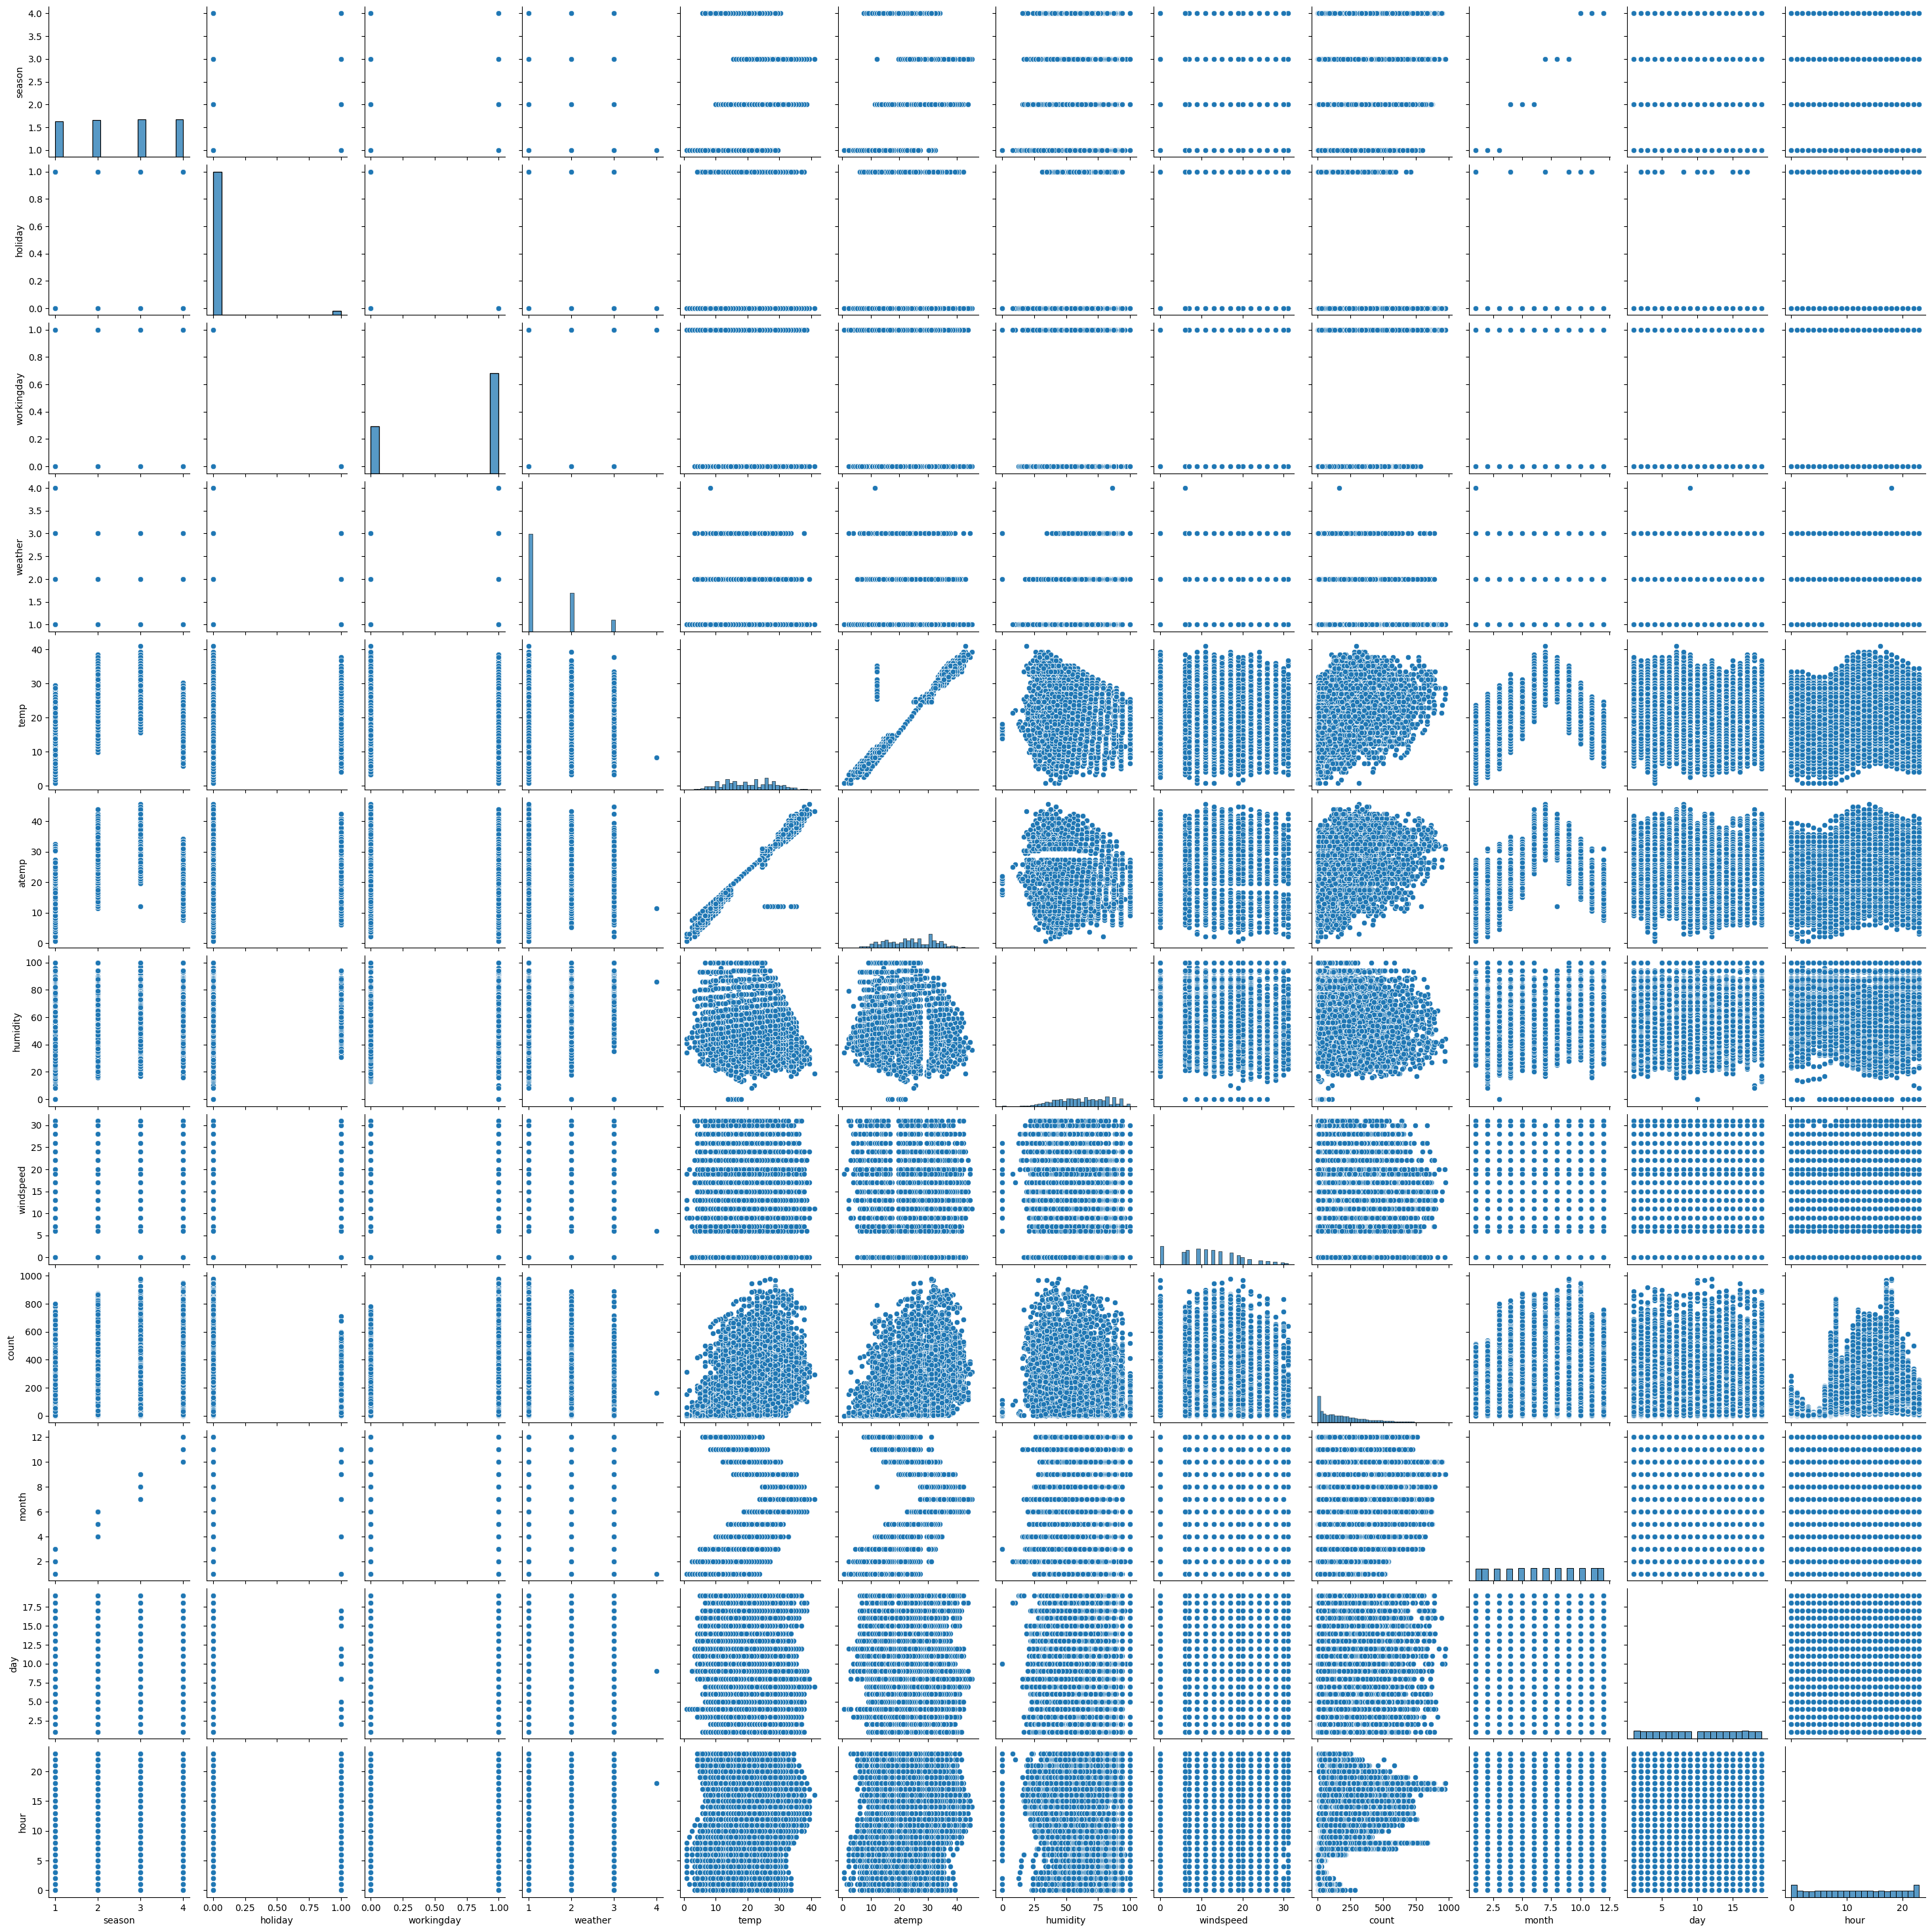

In [13]:
sns.pairplot(df)

In [14]:
X, y = df.copy(deep=True).drop(columns=["count"]), pd.Series(df["count"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [15]:
regressors = {
    "lasso": {"model": Lasso(), "params": {"alpha": [0.1, 0.5, 1.0]}},
    "ridge": {"model": Ridge(), "params": {"alpha": [0.1, 0.5, 1.0]}},
    "elasticnet": {"model": ElasticNet(), "params": {"alpha": [0.1, 0.5, 1.0]}},
    "xgb": {
        "model": XGBRegressor(),
        "params": {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.1, 0.01, 0.001],
        },
    },
    "random_forest": {
        "model": RandomForestRegressor(),
        "params": {"n_estimators": [100, 200, 300], "max_depth": [5, 10, 15]},
    },
    "linear_regression": {"model": LinearRegression(), "params": {}},
    "svr": {"model": SVR(), "params": {"kernel": ["linear", "poly", "rbf"]}},
}

In [16]:
def run_regressors(
    regressors: dict[str, dict], X_train: pd.DataFrame, y_train: pd.Series
) -> Pipeline:

    for regressor, regressor_content in regressors.items():
        if regressor == "xgboost":
            clf = GridSearchCV(
                estimator=regressor_content["model"],
                param_grid=regressor_content["params"],
                cv=2,
                verbose=2,
            )
            le = LabelEncoder()
            le_y_train = le.fit_transform(y_train)
            clf.fit(X_train, le_y_train)
        else:
            clf = GridSearchCV(
                estimator=regressor_content["model"],
                param_grid=regressor_content["params"],
                cv=2,
                verbose=2,
            )
            clf.fit(X_train, y_train)

    return clf.best_estimator_

In [17]:
clf = run_regressors(regressors=regressors, X_train=X_train, y_train=y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time

In [18]:
clf

SVR(kernel='linear')

In [19]:
y_pred = clf.predict(X_test)
acc = clf.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Accuracy: {acc}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

Accuracy: 0.30462926151950087
MSE: 21236.318823722475
MAE: 100.74830782020997
R2: 0.30462926151950087


In [20]:
if not os.path.exists("./models"):
    os.makedirs("./models")

joblib.dump(clf, "./models/regressor.pkl")

['./models/regressor.pkl']